# Exploring covariance between properties across scales
**Authors**: Benjamin Jasperson, Harley T. Johnson

**GitHub URL**: https://github.com/bjasperson/property-covariance-demo

# Background Information

This workbook explores the use of interatomic potential (IP)-generated data to uncover correlations between fundamental microscopic properties, which we call canonical properties, and large-scale quantities of interest (QoI).
It closely follows the work outlined in [this manuscript](https://doi.org/10.1016/j.actamat.2025.120722).

As a proof-of-principle, we'll use grain boundary (GB) energy as our QoI. 
Specifically, we'll look at how canonical properties relate to the scaling factor in the universal lattice matching (LM) model of Runnels et al. (2016).
You don't need to worry about how this coefficient is defined; see the paper for details. Just think of it as a scalar measure of grain boundary energy.

By the end of this workbook, you will have:
1. Explored a dataset of IP-generated property results, uncovering correlations that can be used in a multiscale regression model.
2. Developed a regression model using canonical properties identified through k-fold cross-validation.
3. Used the regression model with first-principles indicator properties to make a prediction for the GB scaling coefficient from first-principles canonical properties.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

from itertools import combinations
from textwrap import wrap

# Download Data
To begin, we need to import our project data. The data we will use is originally from [this manuscript](https://arxiv.org/abs/2411.16770), [published here](https://doi.org/10.1016/j.actamat.2025.120722). You can find the original paper repo [here](https://github.com/Johnson-Research-Group/gb_covariance).

The data includes IP-generated canonical properties, along with an LM model scaling factor calculated from individual symmetric-tilt GB energy simulations.

**Task**: Using pandas, download the CSV file with this [link](https://github.com/bjasperson/property-covariance-demo/blob/main/data/gb_data.csv?raw=true), save the dataframe as `df_data`, and look at the first five rows.

In [2]:
url_link = "https://github.com/bjasperson/property-covariance-demo/blob/main/data/gb_data.csv?raw=true"
df_data = pd.read_csv(url_link, index_col=0)
df_data.head()

,crystal_type,species,model,lattice_constant_bcc,lattice_constant_fcc,lattice_constant_sc,bulk_modulus_bcc,bulk_modulus_fcc,bulk_modulus_sc,c44_bcc,...,unrelaxed_formation_potential_energy_fcc,unrelaxed_formation_potential_energy_hcp,vacancy_migration_energy_bcc,vacancy_migration_energy_fcc,vacancy_migration_energy_hcp,vacancy_migration_energy_sc,relaxation_volume_bcc,relaxation_volume_fcc,relaxation_volume_hcp,coeff
0,fcc,Al,Sim_LAMMPS_MEAM_PascuetFernandez_2015_AlU__SM_...,3.270778,4.049999,2.740228,54.825677,78.890189,46.023445,34.077157,...,1.058020,NaN,NaN,0.610757,NaN,NaN,NaN,4.683538,NaN,1.191668
1,fcc,Al,Sim_LAMMPS_MEAM_PascuetFernandez_2015_Al__SM_8...,3.270778,4.049999,2.740228,54.825677,78.890189,46.023445,34.077157,...,1.058020,NaN,NaN,0.610485,NaN,NaN,NaN,4.681808,NaN,1.191794
2,fcc,Al,Sim_LAMMPS_MEAM_AlmyrasSangiovanniSarakinos_20...,3.252540,4.047000,2.581950,71.601330,79.371087,61.759057,26.806281,...,1.383830,NaN,NaN,0.573611,NaN,NaN,NaN,5.431662,NaN,0.691561
3,fcc,Al,Sim_LAMMPS_MEAM_JelinekGrohHorstemeyer_2012_Al...,3.205723,4.049999,2.702319,81.620977,77.446258,51.141824,30.342210,...,0.841906,NaN,NaN,0.496487,NaN,NaN,NaN,5.362940,NaN,1.134840
4,fcc,Al,EAM_Dynamo_AngeloMoodyBaskes_1995_NiAlH__MO_41...,3.367689,4.050000,2.705041,83.092686,79.372122,86.368413,21.444173,...,0.746775,NaN,NaN,0.179855,NaN,NaN,NaN,5.521970,NaN,0.495295


# Data review
It is important to get a feel for the data that you are working with. To make plotting a little nicer, we have a csv file with key/value pairs to convert the variable names into human readable format.  

**Task**: create a function that will import the label csv file, located at `./data/label_dict.csv`, and convert it to a dictionary called `label_dict` using pandas, for use with plotting. Return the dictionary.

In [3]:
def import_label_dict(label_dict_path = "https://github.com/bjasperson/property-covariance-demo/blob/main/data/label_dict.csv?raw=true"):
    """import the ./data/label_dict.csv file, convert it to a dictionary

    Args:
        label_dict_path (str, optional): path to csv file with key/value pairs.

    Returns:
        dict: a dictionary with df column names as keys, and human-readable label as value
    """
    
    # useful for plotting purposes
    df_label_dict = pd.read_csv(label_dict_path)
    label_dict = df_label_dict.to_dict(orient="records")[0]
    return label_dict

label_dict = import_label_dict()

Now, let's write a function that calculates the [correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) between two variables. 

**Task**: given our dataframe, create a function that uses [Pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) to calculate the correlation coefficient between each set of variables. First, make a copy of the dataframe and replace the column names with the human readable version from the label dictionary using list comprehension. Next, apply the `corr` method to the copied dataframe to create `df_corr`. Finally, sort both the columns *and* rows of `df_corr` based on how correlated the variable is to the scaling factor, `$E_0$`.

In [4]:
def correlation_df(df, label_dict):
    """create df with correlation values

    Args:
        df (pandas.DataFrame): our `df_data` property dataframe 
        label_dict (dict): the label dict from above, to convert label keys to human readable format

    Returns:
        pandas.DataFrame: correlation coefficient between canonical properties and coeff ($E_0$). Sort both the columns and rows by how correlated they are with the coeff $E_0$.
    """
    df_in = df.copy()
    df_in.columns = [label_dict[x] for x in df_in.columns]
    df_corr = df_in.corr().round(2)

    order = df_corr['$E_0$'].sort_values(ascending=False).index.to_list()
    df_corr = df_corr[order].reindex(order)
    return df_corr

We now want to look at how the different fundamental properties relate with each other and our Quantity of Interest (GB energy coefficient). To aid in this, we will look at two plots. First, let's plot a heat map of the correlation coefficient. 

**Task**: first, save the `df_data` columns to a list and remove the non-property columns ("crystal_type", "species", "model"). Write a function that calls the `correlation_df` function you previously created. Use the Seaborn `heatmap` function to plot the correlation coefficient dataframe.

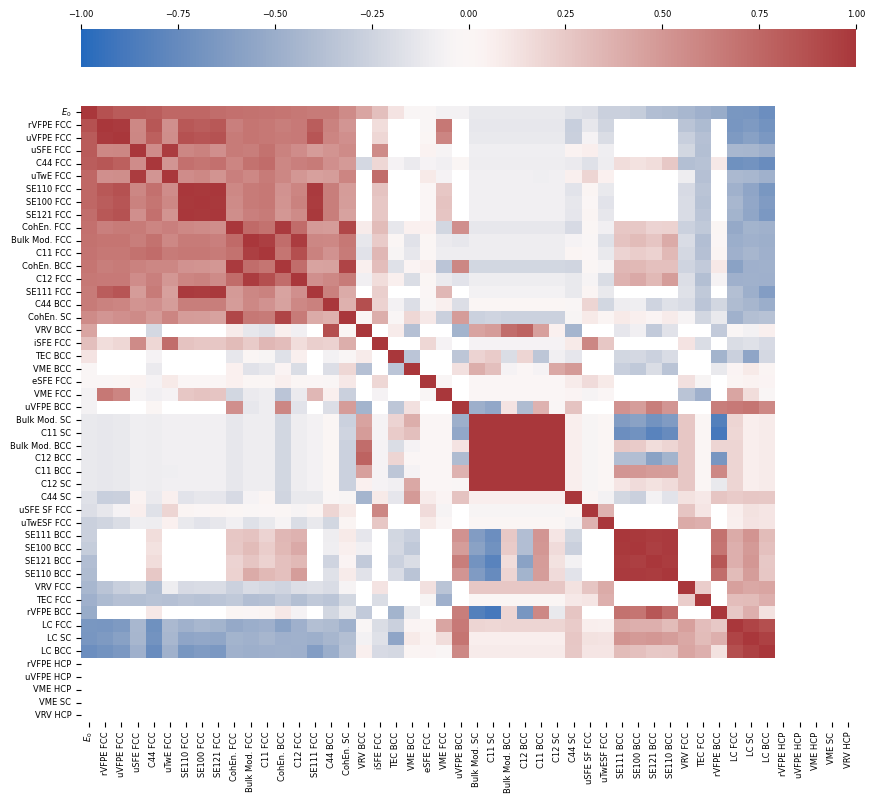

In [5]:
def corr_plot(df, 
              label_list, 
              label_dict, 
              annot = False, 
              figsize = (10,10),
              annotation_fontsize = 6,
              tick_fontsize = 6,
              ):
    """create a heatmap of the correlation coefficient results

    Args:
        df (pandas.DataFrame): our `df_data` property dataframe
        label_list (list): list of property names (str) to include
        label_dict (dict): the label dict from above, to convert label keys to human readable format
        annot (bool, optional): adds the correlation coefficient value to each square. Defaults to False.
        figsize (tuple, optional): set the figure size for plt.subplots. Defaults to (10,10).
        annotation_fontsize (int, optional): annotation fontsize. Defaults to 6.
        tick_fontsize (int, optional): tick fontsize. Defaults to 6.
    """
    df_corr = correlation_df(df[label_list], label_dict)
    fig,ax = plt.subplots(figsize = (figsize[0],figsize[1]))
    colors = sns.color_palette("vlag", as_cmap=True)

    # plot using Seaborn heatmap
    sns.heatmap(df_corr, vmin = -1, vmax = 1, cmap=colors,
                annot=annot,
                xticklabels=True,
                yticklabels=True,
                fmt = '.1f',
                annot_kws = {"fontsize":annotation_fontsize},
                cbar_kws = {"location":"top"}
                )
    ax.tick_params(labelsize=tick_fontsize)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=tick_fontsize)

    return

label_list = df_data.columns.to_list()
label_list.remove("crystal_type")
label_list.remove("species")
label_list.remove("model")
corr_plot(df_data, label_list, label_dict)

Notice how properties that are highly correlated with each other appear as square blocks in the plot. This makes it easy to identify groups of properties that can easily be substituted for each other other in the model. 

Next, let's look at pairplots of the most correlated features. 

**Task**: create a function to plot a set of properties from the property dataframe. Use Seaborn pairplot, and set the marker color (`hue`) based on `species`. Explore different combinations of pairplots for the data.

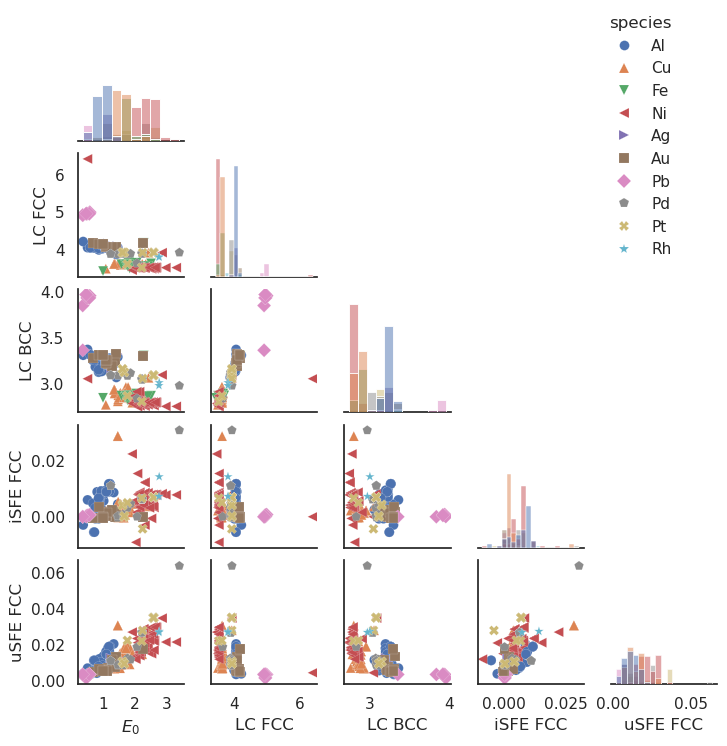

In [6]:
def pairplot_fun(df, 
                 params_list,  
                 label_dict, 
                 height=1.5,
                 ):
    """create pairplot for select indicator properties

    Args:
        df (pandas.DataFrame): dataframe of data that was previously imported
        params_list (list): list of parameter strings to use
        label_dict (dict): the label dict from above, to convert label keys to human readable format
        height (float): pairplot height. Defaults to 2.0.
        xlims (list): list of limits to use for plotting
    """
    if 'species' not in params_list:
        params_list.extend(['species'])
    X = df[params_list]
    X.columns = [label_dict[x] for x in X.columns.to_list()]
    sns.set_theme(style="white", font_scale = 1)
    marker_list = ['o','^','v','<','>','s','D','p','X','*','.','P']
    g = sns.pairplot(X, hue='species', corner=True, markers = marker_list[0:len(df.species.drop_duplicates())],
                     plot_kws=dict(s=50, linewidth=0.1, rasterized = True), 
                     height=height,
                     diag_kind='hist')
    sns.move_legend(g, "upper right", bbox_to_anchor = (0.85,1))

plot_param_list = ["coeff", "lattice_constant_fcc", "lattice_constant_bcc", 'intr_stack_fault_energy_fcc', 'unstable_stack_energy_fcc']
pairplot_fun(df_data, plot_param_list, label_dict)

Some questions to ponder:
1. Did you find factors that you think are worth including?
2. Do you see any outliers that we need to remove? How will you decide what is an outlier?

# Identifying indicator properties

Now that we have our data, we want to figure out which canonical properties will be best for our model. To do that, we'll use a [linear regression model](https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares) with [k-fold cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html#k-fold).

## Develop regression model

**Task**: Write a function that returns a sklearn linear regression pipeline. Your pipeline should include the following steps:
- StandardScaler: for scaling the input values; helpful for SVR, used in LR for consistency. 
- KNNImputer: for filling in the missing property values in our data. Set `n_neighbors=2` and `keep_empty_features=True`
- LinearRegression: the linear regression model (`linear_model.LinearRegression()`).

Combine these into a `Pipeline` to facilitate easy use .

In [7]:
def linear_regr_pipeline():
    """creates a linear regression pipeline for modeling purposes

    Returns:
        sklearn.pipeline.Pipeline: linear regression pipeline
    """

    # Linear regression selection pipeline, used in manuscript
    imput = KNNImputer(n_neighbors=2,
                       weights="uniform",
                       keep_empty_features=True)
    model = linear_model.LinearRegression()

    pipe = Pipeline(steps=[('scale', StandardScaler()),
                            ('imp', imput),
                            ('lr', model)])
    return pipe

pipe = linear_regr_pipeline()

Now, we need to make a list of the properties we are interested in considering as indicator properties for our model. A starting point is provided below.

**If time**: explore different properties, and see if any new additions result in improved models!

In [8]:
# list of parameters to explore
params_list = ['lattice_constant_fcc',
                'bulk_modulus_fcc', 'c11_fcc', 'c12_fcc', 'c44_fcc',
                'extr_stack_fault_energy_fcc', 'intr_stack_fault_energy_fcc', 'unstable_stack_energy_fcc'
                ]

Using the parameter list, we want to make a list of possible combinations up to a certain number of factors. 

**Task**: write a function that uses the `combinations` function from `itertools` to make a list of lists with possible combinations of factors up to `n_factor_max`. Return the list for later use.

In [9]:
def create_subsets_list(factor_list, n_factor_max):
    """create all possible combinations of factors from a list, up to n_factor_max

    Args:
        factor_list (list): a list of individual factors (str) to consider
        n_factor_max (int): maximum number of factors to consider in one model

    Returns:
        list: a list of lists, with each sub-list containing the factors (str) to include (e.g., ['c11_fcc', 'c12_fcc'])
    """
    subsets = []
    for n in range(1, (n_factor_max+1)):
        for subset in combinations(factor_list, n):
            subsets.append(list(subset))
    return subsets

subsets = create_subsets_list(params_list, n_factor_max = 3)
print(subsets)

[['lattice_constant_fcc'], ['bulk_modulus_fcc'], ['c11_fcc'], ['c12_fcc'], ['c44_fcc'], ['extr_stack_fault_energy_fcc'], ['intr_stack_fault_energy_fcc'], ['unstable_stack_energy_fcc'], ['lattice_constant_fcc', 'bulk_modulus_fcc'], ['lattice_constant_fcc', 'c11_fcc'], ['lattice_constant_fcc', 'c12_fcc'], ['lattice_constant_fcc', 'c44_fcc'], ['lattice_constant_fcc', 'extr_stack_fault_energy_fcc'], ['lattice_constant_fcc', 'intr_stack_fault_energy_fcc'], ['lattice_constant_fcc', 'unstable_stack_energy_fcc'], ['bulk_modulus_fcc', 'c11_fcc'], ['bulk_modulus_fcc', 'c12_fcc'], ['bulk_modulus_fcc', 'c44_fcc'], ['bulk_modulus_fcc', 'extr_stack_fault_energy_fcc'], ['bulk_modulus_fcc', 'intr_stack_fault_energy_fcc'], ['bulk_modulus_fcc', 'unstable_stack_energy_fcc'], ['c11_fcc', 'c12_fcc'], ['c11_fcc', 'c44_fcc'], ['c11_fcc', 'extr_stack_fault_energy_fcc'], ['c11_fcc', 'intr_stack_fault_energy_fcc'], ['c11_fcc', 'unstable_stack_energy_fcc'], ['c12_fcc', 'c44_fcc'], ['c12_fcc', 'extr_stack_fault_e

We now have our list of possible factor combinations to consider. If we fit our model to the entire dataset, we aren't getting a realistic picture of the test error. So, we will use the `cross_val_score` package from scikit-learn to perform cross validation. Read more about it [here](https://scikit-learn.org/stable/modules/cross_validation.html).

**Task**: write a function that iterates over each subset of the possible factor combinations. For each subset, use the `cross_val_score` package to perform cross-validation and return a score. 

In [10]:
def factor_select_cv(df, pipe, subsets, label="coeff", cv=None, scoring='r2'):
    """evaluates combinations of factors
    
    return a dataframe that includes one row per factor combination. list of parameters w/ cv score

    Args:
        df (pandas.DataFrame): dataframe of data that was previously imported
        pipe (sklearn.pipeline.Pipeline): scikit-learn pipeline
        subsets (list): a list of lists, with each sub-list containing the factors (str) to include (e.g., ['c11_fcc', 'c12_fcc'])
        label (str, optional): the QoI label to use. Defaults to "coeff".
        cv (int, optional): int, cross-validation generator or an iterable, Determines the cross-validation splitting strategy. Defaults to None.
        scoring (str, optional): A str (see model evaluation documentation) or a scorer callable object / function with signature scorer(estimator, X, y) which should return only a single value. Defaults to 'r2'.

    Returns:
        pandas.DataFrame: a dataframe of CV results
    """
    
    cv_score_mean = []
    cv_score_std = []
    num_factors = []
    for i, subset in enumerate(subsets):
        print(f"{i} of {len(subsets)}")
        print('current subset: ', subset)
        score = cross_val_score(pipe, df[subset], df[label], cv=cv, scoring=scoring, n_jobs = -1)
        print('score mean: ', np.mean(score))
        cv_score_mean.append(np.mean(score))
        cv_score_std.append(np.std(score))
        num_factors.append(len(subset))

    df_results = pd.DataFrame({'factors': subsets,
                               'num_factors': num_factors,
                               'cv_score': cv_score_mean,
                               'cv_score_std': cv_score_std})
    df_results = df_results.sort_values('cv_score', ascending=False)

    return df_results

Now, let's run repeated k-fold CV (`n_splits=10`, `n_repeats=5`) and get the results. Call your previously defined `factor_select_cv` function with `RepeatedKFold` for the cv-generator.

In [11]:
filename = "kfold_models_lr"

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state = 12345)
df_results = factor_select_cv(df_data,
                              pipe, 
                              subsets, 
                              cv=cv, 
                              scoring='neg_root_mean_squared_error')

0 of 92
current subset:  ['lattice_constant_fcc']
score mean:  -0.4756549925435483
1 of 92
current subset:  ['bulk_modulus_fcc']
score mean:  -0.4486535774063443
2 of 92
current subset:  ['c11_fcc']
score mean:  -0.4569354677275004
3 of 92
current subset:  ['c12_fcc']
score mean:  -0.4678475715760774
4 of 92
current subset:  ['c44_fcc']
score mean:  -0.36196299295485107
5 of 92
current subset:  ['extr_stack_fault_energy_fcc']
score mean:  -0.7513486126288186
6 of 92
current subset:  ['intr_stack_fault_energy_fcc']
score mean:  -0.6034401212250393
7 of 92
current subset:  ['unstable_stack_energy_fcc']
score mean:  -0.3880936023562156
8 of 92
current subset:  ['lattice_constant_fcc', 'bulk_modulus_fcc']
score mean:  -0.3895094903957623
9 of 92
current subset:  ['lattice_constant_fcc', 'c11_fcc']
score mean:  -0.39223186106872426
10 of 92
current subset:  ['lattice_constant_fcc', 'c12_fcc']
score mean:  -0.4022962855155053
11 of 92
current subset:  ['lattice_constant_fcc', 'c44_fcc']
scor

**Task**: Sort the values based on "cv_score", with `ascending=False`. 

In [12]:
df_results.sort_values("cv_score", ascending=False)

,factors,num_factors,cv_score,cv_score_std
90,"[c44_fcc, intr_stack_fault_energy_fcc, unstabl...",3,-0.251632,0.114226
84,"[c12_fcc, c44_fcc, unstable_stack_energy_fcc]",3,-0.260438,0.127376
53,"[lattice_constant_fcc, c44_fcc, unstable_stack...",3,-0.263122,0.112700
32,"[c44_fcc, unstable_stack_energy_fcc]",2,-0.264264,0.117505
68,"[bulk_modulus_fcc, c44_fcc, unstable_stack_ene...",3,-0.275064,0.125890
...,...,...,...,...
69,"[bulk_modulus_fcc, extr_stack_fault_energy_fcc...",3,-0.659506,0.629622
85,"[c12_fcc, extr_stack_fault_energy_fcc, intr_st...",3,-0.735938,0.827194
5,[extr_stack_fault_energy_fcc],1,-0.751349,0.381828
54,"[lattice_constant_fcc, extr_stack_fault_energy...",3,-0.786149,0.967111


Pick the top performing model and make a regression model to use. Make predictions and compare predicted versus actual. We will use `KFold` to divide our data up into k folds, so we don't overestimate our model performance.

**Task**: write a function that will fit a pipe against our IP data, using the best model. Use `KFold` to split our data 5 ways. For each fold, fit a new model to the training data and make a prediction for the test data using the pipe. When done, add the predictions to our `df_data` dataframe as "coeff_pred" and return the updated df.

In [13]:
def get_ip_prediction(df, features, label = "coeff"):
    """adds predicted coefficient, with KFold split

    Args:
        df (pandas.DataFrame): dataframe of data that was previously imported
        features (list): parameter strings to include in model
        label (str, optional): name of label property. Defaults to "coeff".

    Returns:
        _type_: _description_
    """
    kf = KFold(n_splits=5, shuffle=True, random_state = 12345)
    predictions = np.zeros(len(df))
    for train_idx, test_idx in kf.split(df):
        X_train, X_test = df[features].iloc[train_idx], df[features].iloc[test_idx]
        y_train, y_test = df[label].iloc[train_idx], df[label].iloc[test_idx]
        pipe = linear_regr_pipeline()
        pipe.fit(X_train, y_train)
        predictions[test_idx] = pipe.predict(X_test)
    df["coeff_pred"] = predictions
    return df

fit_labels = ["c44_fcc", "intr_stack_fault_energy_fcc", "unstable_stack_energy_fcc"]
df_data = get_ip_prediction(df_data, fit_labels)
df_data.head()

,crystal_type,species,model,lattice_constant_bcc,lattice_constant_fcc,lattice_constant_sc,bulk_modulus_bcc,bulk_modulus_fcc,bulk_modulus_sc,c44_bcc,...,unrelaxed_formation_potential_energy_hcp,vacancy_migration_energy_bcc,vacancy_migration_energy_fcc,vacancy_migration_energy_hcp,vacancy_migration_energy_sc,relaxation_volume_bcc,relaxation_volume_fcc,relaxation_volume_hcp,coeff,coeff_pred
0,fcc,Al,Sim_LAMMPS_MEAM_PascuetFernandez_2015_AlU__SM_...,3.270778,4.049999,2.740228,54.825677,78.890189,46.023445,34.077157,...,NaN,NaN,0.610757,NaN,NaN,NaN,4.683538,NaN,1.191668,1.322150
1,fcc,Al,Sim_LAMMPS_MEAM_PascuetFernandez_2015_Al__SM_8...,3.270778,4.049999,2.740228,54.825677,78.890189,46.023445,34.077157,...,NaN,NaN,0.610485,NaN,NaN,NaN,4.681808,NaN,1.191794,1.311201
2,fcc,Al,Sim_LAMMPS_MEAM_AlmyrasSangiovanniSarakinos_20...,3.252540,4.047000,2.581950,71.601330,79.371087,61.759057,26.806281,...,NaN,NaN,0.573611,NaN,NaN,NaN,5.431662,NaN,0.691561,1.209264
3,fcc,Al,Sim_LAMMPS_MEAM_JelinekGrohHorstemeyer_2012_Al...,3.205723,4.049999,2.702319,81.620977,77.446258,51.141824,30.342210,...,NaN,NaN,0.496487,NaN,NaN,NaN,5.362940,NaN,1.134840,1.203123
4,fcc,Al,EAM_Dynamo_AngeloMoodyBaskes_1995_NiAlH__MO_41...,3.367689,4.050000,2.705041,83.092686,79.372122,86.368413,21.444173,...,NaN,NaN,0.179855,NaN,NaN,NaN,5.521970,NaN,0.495295,0.825257


Finally, let's look at our results.

**Task**: write a function that takes in the dataframe, plots the actual coefficient on the horizontal axis, and plots the predicted coefficient on the vertical axis. Use seaborn scatterplot with "species" as the hue. Set the aspect ratio to "equal" for each axis, and plot a line along the diagonal to represent a perfect prediction. 

In [14]:
def pred_vs_actual_plot(df, figsize = (5,5)):
       """plot predicted versus actual data using scatterplot

       Args:
           df (pandas.DataFrame): dataframe of data that was previously imported
           figsize (tuple, optional): _description_. Defaults to (5,5).
       """
       sns.set_style("whitegrid")
       fig,ax = plt.subplots(figsize = (figsize[0],figsize[1]))
       sns.scatterplot(data=df, x='coeff', y='coeff_pred',hue='species',style = 'species')
       ax.plot(np.linspace(0,max(df['coeff']),50),
              np.linspace(0,max(df['coeff']),50))
       ax.set_xlabel(r"actual coefficient [$J/m^2$]", fontsize=8)
       ax.set_ylabel(r"predicted coefficient [$J/m^2$]", fontsize=8)
       ax.tick_params(labelsize=8)      
       ax.axes.set_aspect('equal')
       return

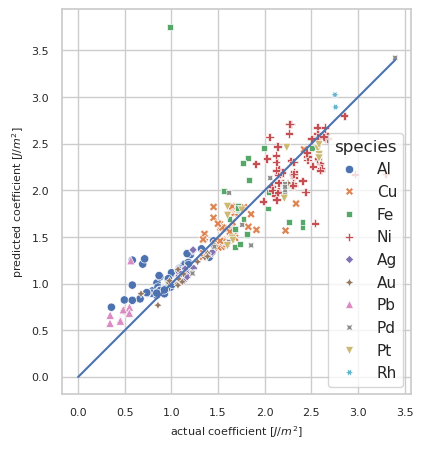

In [15]:
pred_vs_actual_plot(df_data)

# Make predictions from first-principles indicator properties

Now, we will import the DFT data that we will use with our model to make inferred predictions based on the indicator properties. First, get the data.

**Task**: Using pandas, download the CSV file with this [link](https://github.com/bjasperson/property-covariance-demo/blob/main/data/gb_dft.csv?raw=true), save the dataframe as `df_dft`, and look at the first five rows.

In [16]:
url_link = "https://github.com/bjasperson/property-covariance-demo/blob/main/data/gb_dft.csv?raw=true"
df_dft = pd.read_csv(url_link, index_col=0)
df_dft

,species,bulk_modulus_fcc,c44_fcc,C11-C12,surface_energy_111_fcc,surface_energy_121_fcc,surface_energy_100_fcc,unstable_stack_energy_fcc,intr_stack_fault_energy_fcc,lattice_constant_fcc,relaxed_formation_potential_energy_fcc,vacancy_migration_energy_fcc,units,dft_exact_coeff
0,Ag,92.8612,41.2075,31.0503,0.044252,0.050806,0.049370,0.006472,0.001067,4.1457,0.7209,0.6564,"{‘bulk_modulus_unit_fcc’:’GPa’, ‘elastic_const...",1.032129
1,Al,76.0248,33.6604,53.4132,0.050868,0.059045,0.058608,0.010430,0.007602,4.0378,0.6413,0.3347,"{‘bulk_modulus_unit_fcc’:’GPa’, ‘elastic_const...",0.886213
2,Au,144.4053,26.5289,20.9309,0.043441,0.050244,0.054176,0.005418,0.001872,4.1539,0.2512,0.3986,"{‘bulk_modulus_unit_fcc’:’GPa’, ‘elastic_const...",0.842135
3,Cu,133.9783,79.5973,53.4236,0.080203,0.092686,0.090315,0.011104,0.002628,3.6239,0.8481,0.6623,"{‘bulk_modulus_unit_fcc’:’GPa’, ‘elastic_const...",1.551010
4,Ni,206.5840,117.5921,83.1221,0.114032,0.140808,0.139810,0.017851,0.008919,3.5036,1.2142,1.0189,"{‘bulk_modulus_unit_fcc’:’GPa’, ‘elastic_const...",2.302325
5,Pd,169.9014,59.5413,47.5747,0.083823,0.096057,0.096057,0.014168,0.009100,3.9342,0.9624,0.8261,"{‘bulk_modulus_unit_fcc’:’GPa’, ‘elastic_const...",1.686351
6,Pt,255.1226,60.4932,88.9141,0.092624,0.103671,0.115780,0.019973,0.018993,3.9650,0.3939,1.3078,"{‘bulk_modulus_unit_fcc’:’GPa’, ‘elastic_const...",1.632912


We have two sets of properties now to consider: one for the IP data, and one for the DFT data. We want to decide which model to use for the DFT data. Let's filter our k-fold CV results to only include the DFT canonical properties.

**Task:** Write a function that filters your model performance list from above based on the DFT properties available. Take in the cv results dataframe and a list of DFT properties (from the df_dft columns). If the properties for a given row are all available with DFT results, include it ([hint](https://www.geeksforgeeks.org/python-check-if-the-list-contains-elements-of-another-list/)). Return a dataframe of new, filtered results. Take a look at the top 5 results.

In [17]:
def filter_cv_results(df, dft_list):
    """takes in a df of k-fold CV results, and filters based on a list of properties

    Args:
        df (pandas.DataFrame): the k-fold CV df from above
        dft_list (list): list of properties available from df_dft

    Returns:
        pandas.DataFrame: filtered results from k-fold CV df
    """
    results = []
    for i, row in df.iterrows():
        factors = row.factors
        if all(factor in dft_list for factor in factors):
            results.append(row)
    return pd.DataFrame(results)

df_result_dft_only = filter_cv_results(df_results, df_dft.columns.to_list())
df_result_dft_only.head()

,factors,num_factors,cv_score,cv_score_std
90,"[c44_fcc, intr_stack_fault_energy_fcc, unstabl...",3,-0.251632,0.114226
53,"[lattice_constant_fcc, c44_fcc, unstable_stack...",3,-0.263122,0.112700
32,"[c44_fcc, unstable_stack_energy_fcc]",2,-0.264264,0.117505
68,"[bulk_modulus_fcc, c44_fcc, unstable_stack_ene...",3,-0.275064,0.125890
56,"[lattice_constant_fcc, intr_stack_fault_energy...",3,-0.301371,0.062870


**Task:** Make a list that identifies the factors from the top performing model. Using your previously created function `add_pred`, make a prediction from DFT indicator properties and add the results to `df_dft` under the name "dft_pred_coeff".

In [18]:
def get_dft_prediction(model_features):
    """get dft coefficient prediction and add to df as "dft_pred_coeff"

    Args:
        model_features (list): list of properties (str) to include in model

    Returns:
        pandas.DataFrame: df_dft with prediction added 
    """ 

    # create new pipeline
    dft_pipe = linear_regr_pipeline()

    # fit dft pipe to IP data
    dft_pipe.fit(df_data[model_features], df_data["coeff"])
    df_dft["dft_pred_coeff"] = dft_pipe.predict(df_dft[model_features])

    return df_dft

# best model of the 5 available DFT properties
dft_model_properties = ['c44_fcc',
                        'intr_stack_fault_energy_fcc',
                        'unstable_stack_energy_fcc',
                    ]

df_dft = get_dft_prediction(dft_model_properties)

Now, use the plotting function provided below to show a boxplot of coefficient results, along with the predicted versus actual DFT coefficient.

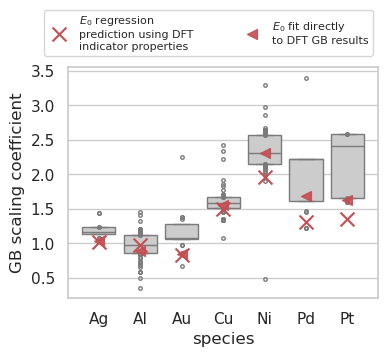

In [19]:
def get_boxplot(df_ip, 
                df_dft, 
                plot_errorbar = True,
                order_list = ["Ag","Al","Au","Cu","Ni","Pd","Pt"]):
    """plot boxplot of dft GB results
    """
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=(4,3))
    sns.boxplot(data = df_ip, 
                x="species", 
                y="coeff", 
                order=order_list, 
                color = "0.8", 
                linewidth=1.0,
                fliersize=5.0,
                whis=0,
                flierprops={"marker":"."},
                zorder=1)
    ax.set_ylabel("GB scaling coefficient")

    # add dft Xs
    ax.scatter(df_dft['species'],
               df_dft['dft_pred_coeff'], 
               marker='x', 
               s=100., 
               alpha=1.0, 
               color="r",
               label='\n'.join(wrap(r"$E_0$ regression prediction using DFT indicator properties",20)),
               zorder=3)

    df_dft_gb_plot = df_dft[['species','dft_exact_coeff']].drop_duplicates()
    df_dft_gb_plot = df_dft_gb_plot[df_dft_gb_plot['species'].isin(order_list)]
    ax.scatter(df_dft_gb_plot['species'],
               df_dft_gb_plot['dft_exact_coeff'], 
               marker='<', 
               s=50., 
               alpha=0.9, 
               color="r",
               label='\n'.join(wrap(r"$E_0$ fit directly to DFT GB results",20)),
               zorder=2)

    # add errorbars if desired
    if plot_errorbar == True:
        ax.errorbar(df_dft['species'],
                    df_dft['regr_coeff'], 
                    yerr = (df_dft['regr_coeff_lower'],
                            df_dft['regr_coeff_upper']), 
                            fmt='.', 
                            markersize=0.0001, 
                            alpha=0.5, 
                            color="r",
                            #label='\n'.join(wrap("Predicted strength using DFT indicator properties",20)),
                            elinewidth=2.0,
                            capsize = 4)

    fig.legend(bbox_to_anchor = (0.05,0.9,0.85,.15),#(0.,1.02,1.,.102),
                    loc='lower left',
                    mode="expand",
                    ncol = 2,
                    fontsize= 8)

    return 

get_boxplot(df_data, df_dft, plot_errorbar=False)

That's it! We see that our model predictions match the DFT results pretty well. 

Additional areas to explore, as time permits:
- Right now, we are using all IP data to fit our model against, then make a prediction. To better estimate the predictive power of our model, we should reserve some data as test data. It makes sense to use cross-validation and report the average error, given our small dataset. Add in cross-validation to make it a more realistic prediction.
- Using different combinations of factors, try to find a better model!
- Explore different model types other than linear regression: SVR, ensemble of regressors, ...
    - see [here](https://scikit-learn.org/stable/machine_learning_map.html) for ideas
- Repeat the process, this time with the strength data
    - [URL link to data](https://github.com/bjasperson/property-covariance-demo/blob/main/data/strength_data.csv?raw=true)